In [1]:
import argparse
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torch
import numpy as np 

from preprocess import get_mnist, get_webcam
from train import TrainerVaDE

In [2]:
class Args:
    batch_size = 128
    lr = 1e-4
    dataset = 'mnist'
    pretrain = True
    epochs = 100
    n_shots = 1


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    
args = Args() # Parsing all the arguments for the training
if args.dataset == 'mnist':
    dataloader_train, dataloader_test = get_mnist(args)
    n_classes = 10
else:
    dataloader_train, dataloader_test = get_webcam(args)
    n_classes = 31

In [3]:
vade = TrainerVaDE(args, device, dataloader_train, dataloader_test, n_classes)

In [4]:
if args.dataset == 'webcam':
    classes = ['back_pack',
                'bike',
                'bike_helmet',
                'bookcase',
                'bottle',
                'calculator',
                'desk_chair',
                'desk_lamp',
                'desktop_computer',
                'file_cabinet',
                'headphones',
                'keyboard',
                'laptop_computer',
                'letter_tray',
                'mobile_phone',
                'monitor',
                'mouse',
                'mug',
                'paper_notebook',
                'pen',
                'phone',
                'printer',
                'projector',
                'punchers',
                'ring_binder',
                'ruler',
                'scissors',
                'speaker',
                'stapler',
                'tape_dispenser',
                'trash_can']
else:
    classes = ['0',
               '1',
               '2',
               '3',
               '4',
               '5',
               '6',
               '7',
               '8',
               '9']


def get_latent_space(dataloader, z_dim, model, device, ftr_ext=None):
    z = torch.zeros((1, z_dim)).float().to(device)
    y = torch.zeros((1)).long().to(device)
    with torch.no_grad():
        for img, label in dataloader:
            img, label = img.to(device).float(), label.to(device).long()
            if ftr_ext is not None:
                img = ftr_ext(img); img = img.detach()

            mu, log_var = model.encode(img)
            z_l = model.reparameterize(mu, log_var)
            y = torch.cat((y, label), dim=0)
            z = torch.cat((z, z_l), dim=0)
    return z[1:], y[1:]


def plot_tsne(X_embedded, y, ticks, dataset):
    f, ax1 = plt.subplots(1, 1, sharey=True, figsize=(15,10))

    cmap = plt.get_cmap('jet', 10)


    cax = ax1.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y.numpy(),
                      s=15, cmap=cmap)

    cbar = f.colorbar(cax, ticks=np.linspace(0,30,31))
    cbar.ax.set_yticklabels(ticks)

    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    plt.savefig('weights/vade_tsne_{}'.format(dataset))

    plt.show()

In [5]:
vade.train()

Training VaDE...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Testing VaDE... Epoch: -1, Loss: 191.71008493930478, Acc: 62.2626582278481
Training VaDE... Epoch: 0, Loss: 168.6373918610595, Acc: 86.332289445629
Testing VaDE... Epoch: 0, Loss: 161.20969497101217, Acc: 93.01819620253164
Training VaDE... Epoch: 1, Loss: 159.50942820729986, Acc: 93.71668443496802
Testing VaDE... Epoch: 1, Loss: 157.92053338545787, Acc: 94.41257911392405
Training VaDE... Epoch: 2, Loss: 156.9643371842309, Acc: 94.87773187633262
Testing VaDE... Epoch: 2, Loss: 155.9965059304539, Acc: 95.51028481012658
Training VaDE... Epoch: 3, Loss: 155.4432707829262, Acc: 95.62566631130063
Testing VaDE... Epoch: 3, Loss: 155.2693465993374, Acc: 95.32238924050633
Training VaDE... Epoch: 4, Loss: 154.43789402813292, Acc: 96.02489783226724
Testing VaDE... Epoch: 4, Loss: 154.39592173129697, Acc: 95.63884493670886
Training VaDE... Epoch: 5, Loss: 153.635174423901, Acc: 96.38026385927505
Testing VaDE... Epoch: 5, Loss: 153.8301179137411, Acc: 95.94541139240506
Training VaDE... Epoch: 6, Lo

Training VaDE... Epoch: 54, Loss: 147.89544742803838, Acc: 99.30870202558636
Testing VaDE... Epoch: 54, Loss: 149.60453970221025, Acc: 97.8243670886076
Training VaDE... Epoch: 55, Loss: 147.84861485332823, Acc: 99.34701492537313
Testing VaDE... Epoch: 55, Loss: 149.87546491019333, Acc: 97.43868670886076
Training VaDE... Epoch: 56, Loss: 147.89511066103287, Acc: 99.29537579957356
Testing VaDE... Epoch: 56, Loss: 149.84350682512115, Acc: 97.5573575949367
Training VaDE... Epoch: 57, Loss: 147.87772826497743, Acc: 99.30148365316276
Testing VaDE... Epoch: 57, Loss: 149.77112164074862, Acc: 97.62658227848101
Training VaDE... Epoch: 58, Loss: 147.8262589054067, Acc: 99.35201226012794
Testing VaDE... Epoch: 58, Loss: 149.67723083496094, Acc: 97.71558544303798
Training VaDE... Epoch: 59, Loss: 147.8098031961079, Acc: 99.35201226012794
Testing VaDE... Epoch: 59, Loss: 149.69798626477206, Acc: 97.62658227848101
Training VaDE... Epoch: 60, Loss: 147.7470040717867, Acc: 99.39643301350391
Testing Va

In [6]:
z_dim = 10
model = vade.VaDE
z, y = get_latent_space(dataloader_test, z_dim, model, device)
z, y = z.cpu(), y.cpu()
z_embedded = TSNE(n_components=2).fit_transform(z.detach().numpy())

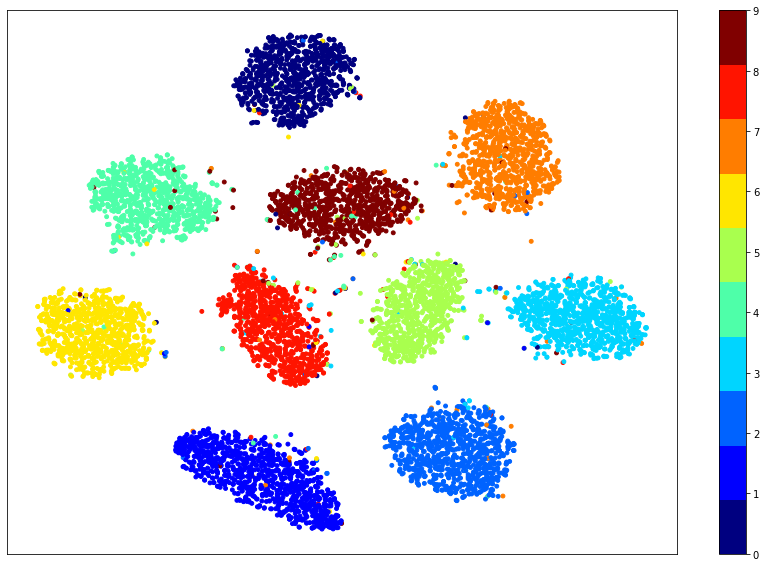

In [7]:
plot_tsne(z_embedded, y, classes, args.dataset)

In [8]:
acc = np.array(vade.acc)
acc_t = np.array(vade.acc_t)
rec = np.array(vade.rec)
rec_t = np.array(vade.rec_t)
dkl = np.array(vade.dkl)
dkl_t = np.array(vade.dkl_t)

def plot_loss(values, values_t, metric, dataset):
    plt.plot(np.arange(len(values)), values, c='k', label='train')
    plt.plot(np.arange(len(values_t)), values_t, c='b', label='test')
    plt.title('VaDE {}'.format(metric))
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.grid(True)
    plt.savefig('weights/vade_{}_{}'.format(metric, dataset))

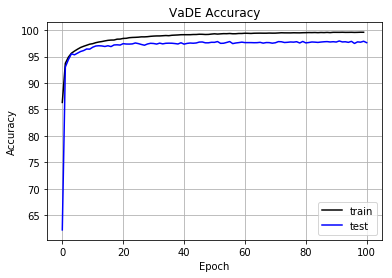

In [9]:
plot_loss(acc, acc_t, 'Accuracy', args.dataset)

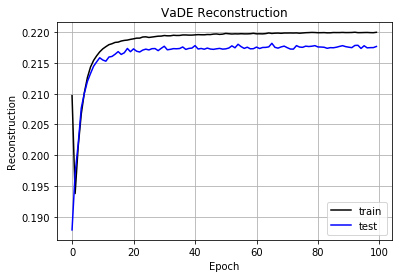

In [10]:
plot_loss(rec, rec_t[1:], 'Reconstruction', args.dataset)

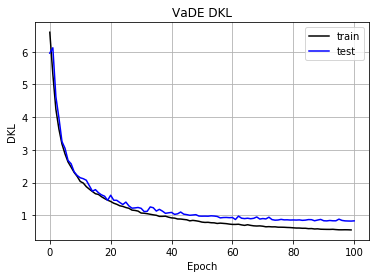

In [11]:
plot_loss(dkl, dkl_t, 'DKL', args.dataset)